In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#### Считайте датасет из файла loan_prediction_dataset.csv (это данные о кредитных заявках)

In [54]:
file_path = "loan_prediction_dataset.csv"
df = pd.read_csv(file_path)

In [55]:
df

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
610,LP002979,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y
611,LP002983,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
612,LP002984,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y


#### Выведите таблицу пропусков по каждому столбцу: абсолютное число и % - 1 балл

In [56]:
missing_count = df.isnull().sum()
missing_percent = (df.isnull().mean() * 100).round(2)


missing_table = pd.DataFrame({
    "Missing Values": missing_count,
    "Percent (%)": missing_percent
})

In [57]:
missing_table

,Missing Values,Percent (%)
Loan_ID,0,0.00
Gender,13,2.12
Married,3,0.49
Dependents,15,2.44
Education,0,0.00
Self_Employed,32,5.21
ApplicantIncome,0,0.00
CoapplicantIncome,0,0.00
LoanAmount,22,3.58
Loan_Amount_Term,14,2.28


#### Постройте графики для пропущенных значений: матрицу и тепловую карту

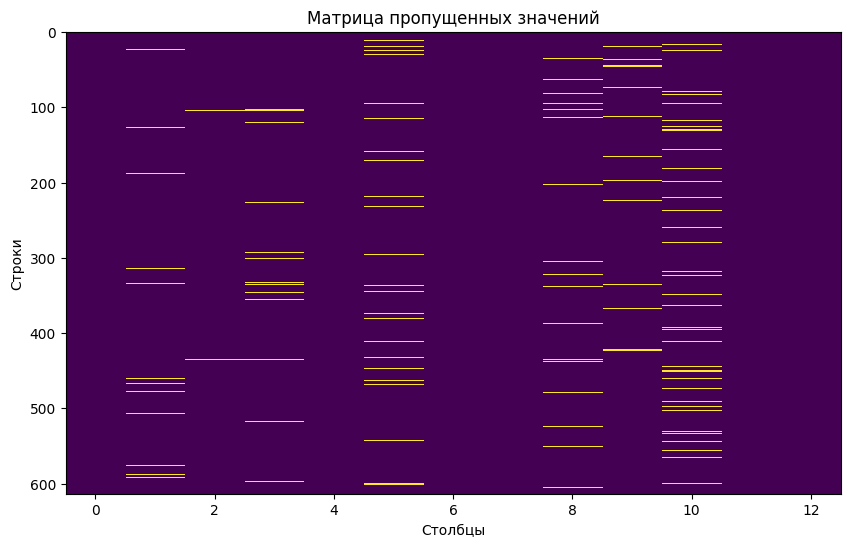

In [58]:
plt.figure(figsize=(10, 6))
plt.imshow(df.isnull(), aspect='auto', interpolation='none', cmap='viridis')
plt.title("Матрица пропущенных значений")
plt.xlabel("Столбцы")
plt.ylabel("Строки")
plt.show()

Часть опрашиваемых не указали семейное положение, количество иждивенцев или данные о работе.

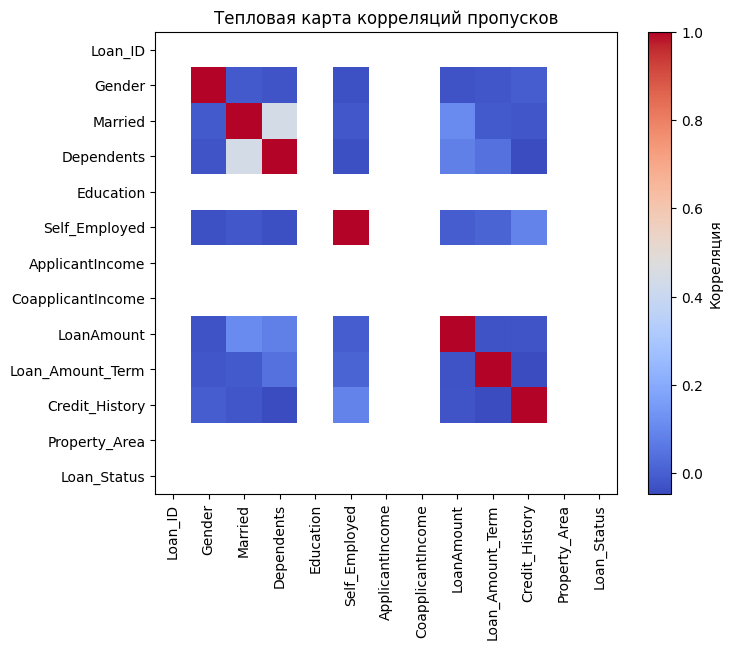

In [59]:
missing_corr = df.isnull().corr()

plt.figure(figsize=(8, 6))
plt.imshow(missing_corr, cmap='coolwarm')
plt.colorbar(label='Корреляция')
plt.title("Тепловая карта корреляций пропусков")
plt.xticks(range(len(df.columns)), df.columns, rotation=90)
plt.yticks(range(len(df.columns)), df.columns)
plt.show()

#### Проинтепретируйте полученный график

В данном кейсе заметных сильных корреляций нет, кроме отдельных случаев:
- Gender / Married: люди, не указавшие пол, чаще не указали семейное положение
- LoanAmount / Loan_Amount_Term: Если человек не указал сумму, вероятно он не указывал и срок кредита
- Loan_Amount_Term / Credit_History: Если пропущен срок кредита, часто пропущена и кредитная история. Возможно, это  клиенты, которые не имеют кредитной истории

#### Разделите данные с пропусками на числовые и категориальные

In [60]:
cols_with_na = df.columns[df.isnull().any()]
df_missing = df[cols_with_na]

numeric_missing = (
    df_missing
    .select_dtypes(include=["int64", "float64"])
    .drop(columns=["Credit_History"], errors="ignore")
)
categorical_missing = df_missing.select_dtypes(include=["object"])

#### Заполните пропуски, обоснуйте выбранные методы

In [61]:
df_before = df.copy()

Пропущенные значения в данных о кредитной истории заполним новым значением, т.к. не можем с уверенностью сказать из-за чего этих данных нет. Допустим, это значение будет -1 (нет кредитной истории)

In [62]:
df['Credit_History'] = df['Credit_History'].fillna(-1)

Пропуски в числовых данных  заполняем медианой, т.к. она устойчива к выбросам.

В кредитных данных часто бывают асимметричные распределения доходов и сумм кредитов, среднее могло бы их исказить.

In [63]:
numeric_filled = numeric_missing.copy()

for col in numeric_filled.columns:
    numeric_filled[col] = numeric_filled[col].fillna(numeric_filled[col].median())

Категориальные признаки заполняем модой. Считаем, что в нашем случае пропуски в категориальных данных обычно означают неуказанный/неизвестный ответ, а мы хотим сохранить частотное распределение.

In [64]:
categorical_filled = categorical_missing.copy()

for col in categorical_filled.columns:
    categorical_filled[col] = categorical_filled[col].fillna(categorical_filled[col].mode()[0])

In [65]:
# Возвращаем заполненные копии в df
df[numeric_filled.columns] = numeric_filled
df[categorical_filled.columns] = categorical_filled

#### Проверьте, что пропуски заполнились корректно

In [66]:
missing_count = df.isnull().sum()
missing_count

,0
Loan_ID,0
Gender,0
Married,0
Dependents,0
Education,0
Self_Employed,0
ApplicantIncome,0
CoapplicantIncome,0
LoanAmount,0
Loan_Amount_Term,0


#### Покажите статистики до/после заполнения

In [67]:
print("Статистики ДО заполнения:\n", df_before.describe())
print("\nСтатистики ПОСЛЕ заполнения:\n", df.describe())

Статистики ДО заполнения:
        ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
count       614.000000         614.000000  592.000000         600.00000   
mean       5403.459283        1621.245798  146.412162         342.00000   
std        6109.041673        2926.248369   85.587325          65.12041   
min         150.000000           0.000000    9.000000          12.00000   
25%        2877.500000           0.000000  100.000000         360.00000   
50%        3812.500000        1188.500000  128.000000         360.00000   
75%        5795.000000        2297.250000  168.000000         360.00000   
max       81000.000000       41667.000000  700.000000         480.00000   

       Credit_History  
count      564.000000  
mean         0.842199  
std          0.364878  
min          0.000000  
25%          1.000000  
50%          1.000000  
75%          1.000000  
max          1.000000  

Статистики ПОСЛЕ заполнения:
        ApplicantIncome  CoapplicantIncome  LoanAmo

#### Для ApplicantIncome и LoanAmount найдите выбросы двумя способами: IQR-правило и std

In [68]:
# Ищем выбросы для ApplicantIncome и LoanAmount

cols = ['ApplicantIncome', 'LoanAmount']

for col in cols:
    print(f"\n=== Анализ выбросов для {col} ===")

    # IQR
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_iqr = Q1 - 1.5 * IQR
    upper_iqr = Q3 + 1.5 * IQR

    outliers_iqr = df[(df[col] < lower_iqr) | (df[col] > upper_iqr)]
    print(f"IQR-границы: [{lower_iqr:.2f}, {upper_iqr:.2f}]")
    print(f"Количество выбросов (IQR): {len(outliers_iqr)}")

    # STD
    mean = df[col].mean()
    std = df[col].std()
    lower_std = mean - 3 * std
    upper_std = mean + 3 * std

    outliers_std = df[(df[col] < lower_std) | (df[col] > upper_std)]
    print(f"STD-границы: [{lower_std:.2f}, {upper_std:.2f}]")
    print(f"Количество выбросов (STD): {len(outliers_std)}")



=== Анализ выбросов для ApplicantIncome ===
IQR-границы: [-1498.75, 10171.25]
Количество выбросов (IQR): 50
STD-границы: [-12923.67, 23730.58]
Количество выбросов (STD): 8

=== Анализ выбросов для LoanAmount ===
IQR-границы: [3.50, 261.50]
Количество выбросов (IQR): 41
STD-границы: [-106.57, 398.07]
Количество выбросов (STD): 15


#### Сравните пересечение/расхождения списков наблюдений; коротко объясните причины

In [69]:
# Сравнение пересечений и расхождений для ApplicantIncome и LoanAmount

cols = ['ApplicantIncome', 'LoanAmount']

for col in cols:
    print(f"\n=== {col} ===")

    # IQR
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_iqr = Q1 - 1.5 * IQR
    upper_iqr = Q3 + 1.5 * IQR
    outliers_iqr = df[(df[col] < lower_iqr) | (df[col] > upper_iqr)]

    # STD
    mean = df[col].mean()
    std = df[col].std()
    lower_std = mean - 3 * std
    upper_std = mean + 3 * std
    outliers_std = df[(df[col] < lower_std) | (df[col] > upper_std)]

    # Пересечение и расхождения
    common = set(outliers_iqr.index).intersection(set(outliers_std.index))
    only_iqr = set(outliers_iqr.index) - set(outliers_std.index)
    only_std = set(outliers_std.index) - set(outliers_iqr.index)

    print(f"Общие выбросы: {len(common)}")
    print(f"Только по IQR: {len(only_iqr)}")
    print(f"Только по STD: {len(only_std)}")


=== ApplicantIncome ===
Общие выбросы: 8
Только по IQR: 42
Только по STD: 0

=== LoanAmount ===
Общие выбросы: 15
Только по IQR: 26
Только по STD: 0


IQR основано на медиане и квартилях т.е. оно не зависит от формы распределения. Ловит больше выбросов, особенно если распределение асимметричное.
STD предполагает, что данные близки к нормальному распределению.

У нас распределения асимметричные, с выраженным правым хвостом (есть люди с очень высокими доходами и крупными кредитами).

#### Визуально подтвердите (boxplot/гистограмма)

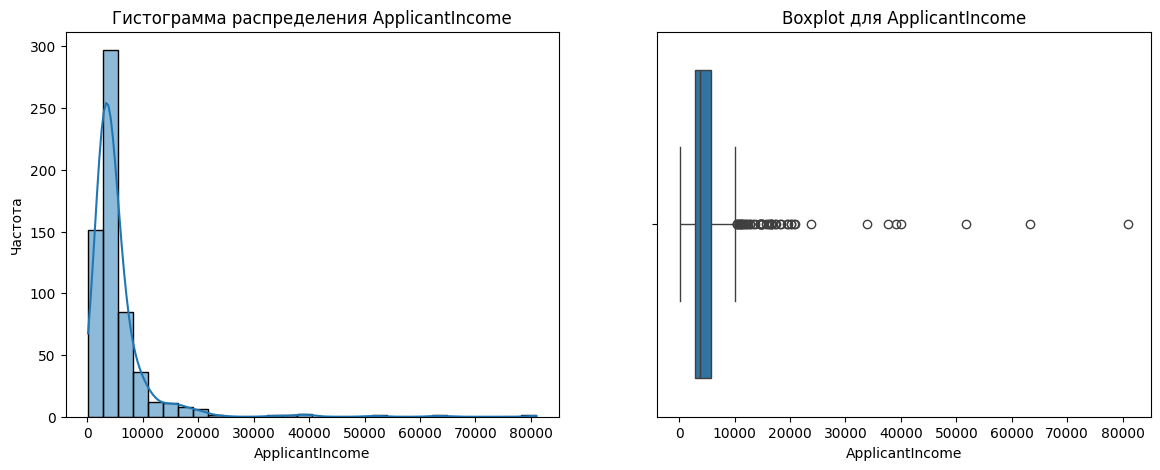

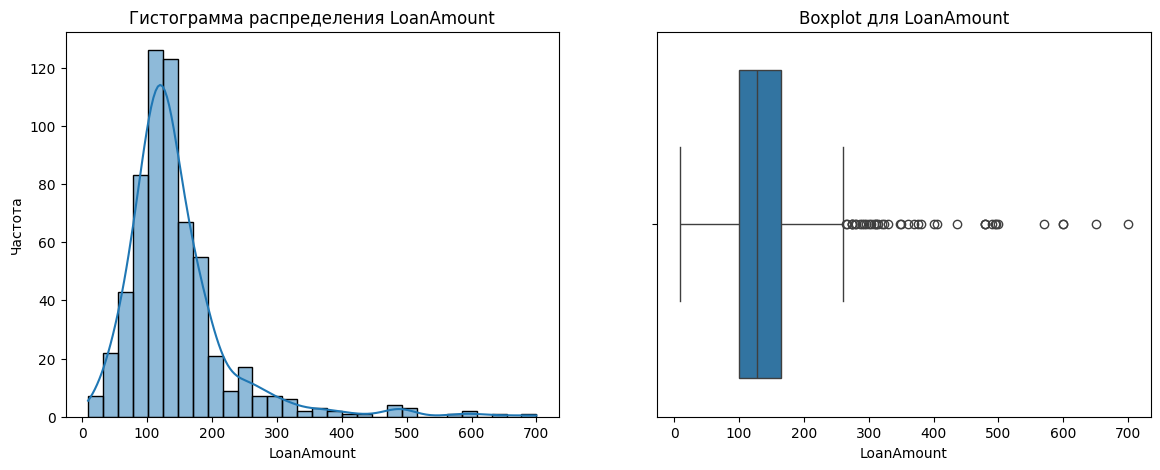

In [70]:
cols = ['ApplicantIncome', 'LoanAmount']

for col in cols:
    plt.figure(figsize=(14,5))

    plt.subplot(1,2,1)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f"Гистограмма распределения {col}")
    plt.xlabel(col)
    plt.ylabel("Частота")

    plt.subplot(1,2,2)
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot для {col}")
    plt.xlabel(col)

    plt.show()

Также сравним выбросы по IQR и STD

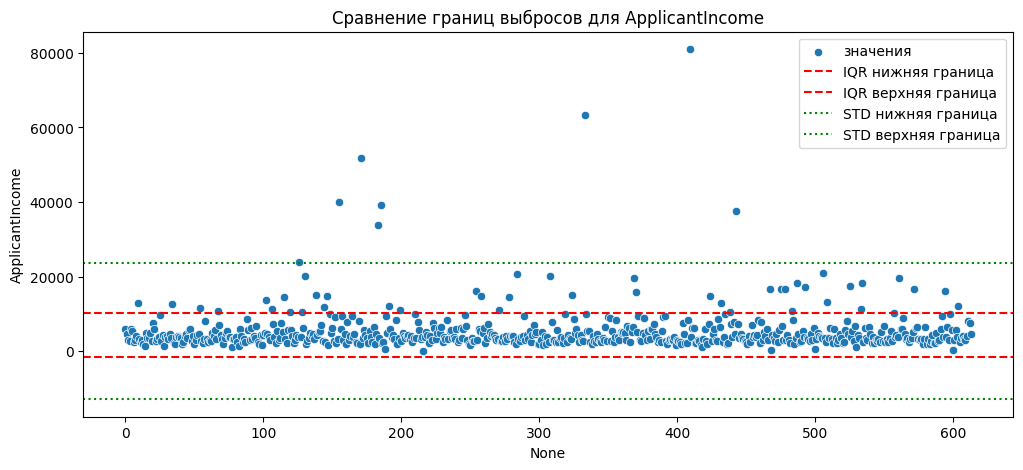

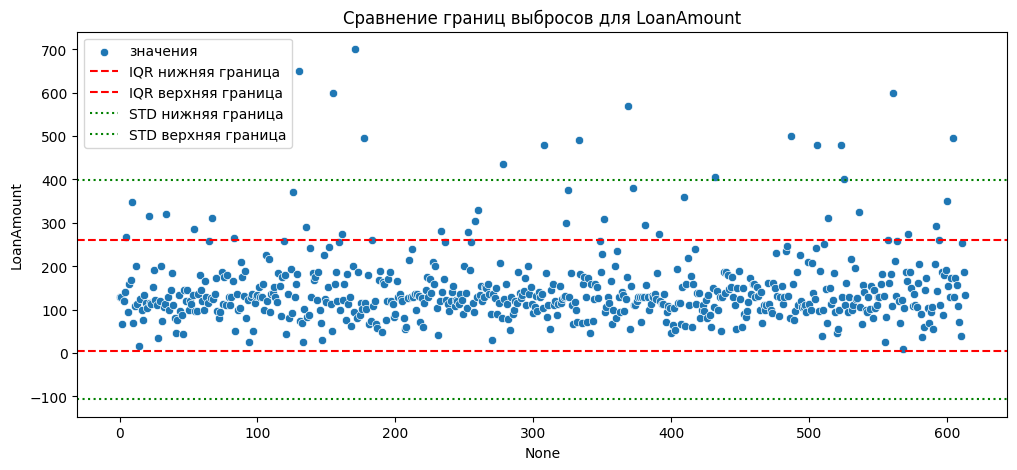

In [71]:
for col in cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_iqr = Q1 - 1.5 * IQR
    upper_iqr = Q3 + 1.5 * IQR

    mean = df[col].mean()
    std = df[col].std()
    lower_std = mean - 3*std
    upper_std = mean + 3*std

    plt.figure(figsize=(12,5))
    sns.scatterplot(x=df.index, y=df[col], label="значения")
    plt.axhline(lower_iqr, color='red', linestyle='--', label='IQR нижняя граница')
    plt.axhline(upper_iqr, color='red', linestyle='--', label='IQR верхняя граница')
    plt.axhline(lower_std, color='green', linestyle=':', label='STD нижняя граница')
    plt.axhline(upper_std, color='green', linestyle=':', label='STD верхняя граница')
    plt.title(f"Сравнение границ выбросов для {col}")
    plt.legend()
    plt.show()


#### Предложите варианты кодирования категориальных переменных, обоснуйте

Используем бинарное кодирование там, где у нас всего 2 значения

In [72]:
cols = set(df.columns)

# Gender: Male=1, Female=0 (надеюсь, в этом нет сексизма)
if {'Gender'}.issubset(cols):
    df['Gender_bin'] = df['Gender'].map({'Male': 1, 'Female': 0}).astype('Int64')

# Married: Yes=1, No=0
if {'Married'}.issubset(cols):
    df['Married_bin'] = df['Married'].map({'Yes': 1, 'No': 0}).astype('Int64')

# Self_Employed: Yes=1, No=0
if {'Self_Employed'}.issubset(cols):
    df['Self_Employed_bin'] = df['Self_Employed'].map({'Yes': 1, 'No': 0}).astype('Int64')

# Education: Graduate=1, Not Graduate=0
if {'Education'}.issubset(cols):
    df['Education_bin'] = df['Education'].map({'Graduate': 1, 'Not Graduate': 0}).astype('Int64')

In [73]:
# Преобразуем целевую переменную Loan_Status
if {'Loan_Status'}.issubset(cols):
    df['Loan_Status'] = df['Loan_Status'].map({'Y': 1, 'N': 0}).astype('Int64')

Используем порядковое кодирование для столбцов, в которых есть порядок (кол-во иждевенцов)
'0'<'1'<'2'<'3+'  -> 0,1,2,3

In [74]:
if {'Dependents'}.issubset(cols):
    df['Dependents_ord'] = (
        df['Dependents']
        .replace({'3+': 3})
        .astype(int)
    )

Используем One-Hot Encoding для номинальных переменных с >2 категориями без порядка

In [75]:
ohe_frames = []

# Property_Area: Urban/Semiurban/Rural
if {'Property_Area'}.issubset(cols):
    prop_dummies = pd.get_dummies(df['Property_Area'], prefix='Property', drop_first=False)
    ohe_frames.append(prop_dummies)

# Credit_History: -1 (нет истории), 0, 1
if {'Credit_History'}.issubset(cols):
    ch_cat = df['Credit_History'].astype(int).astype(str)
    ch_dummies = pd.get_dummies(df['Credit_History'].astype(int).astype(str), prefix='CreditHistory', drop_first=False)
    ohe_frames.append(ch_dummies)

df = pd.concat([df, prop_dummies, ch_dummies], axis=1)

In [76]:
df.filter(like="CreditHistory")

,CreditHistory_-1,CreditHistory_0,CreditHistory_1
0,False,False,True
1,False,False,True
2,False,False,True
3,False,False,True
4,False,False,True
...,...,...,...
609,False,False,True
610,False,False,True
611,False,False,True
612,False,False,True


#### Проверьте результат

Уберем столбцы, которые мы преобразовали и выведем новый дата фрейм

In [81]:
df_ready = df.copy()
cols_to_drop = [
    'Gender',
    'Married',
    'Self_Employed',
    'Education',
    'Dependents',
    'Property_Area'
]


df_ready = df_ready.drop(columns=cols_to_drop)
dummy_cols = [
    'Property_Rural', 'Property_Semiurban', 'Property_Urban',
    'CreditHistory_-1', 'CreditHistory_0', 'CreditHistory_1'
]

df[dummy_cols] = df[dummy_cols].astype(int)

In [80]:
df_ready

,Loan_ID,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Gender_bin,Married_bin,Self_Employed_bin,Education_bin,Dependents_ord,Property_Rural,Property_Semiurban,Property_Urban,CreditHistory_-1,CreditHistory_0,CreditHistory_1
0,LP001002,5849,0.0,128.0,360.0,1.0,1,1,0,0,1,0,0,0,1,0,0,1
1,LP001003,4583,1508.0,128.0,360.0,1.0,0,1,1,0,1,1,1,0,0,0,0,1
2,LP001005,3000,0.0,66.0,360.0,1.0,1,1,1,1,1,0,0,0,1,0,0,1
3,LP001006,2583,2358.0,120.0,360.0,1.0,1,1,1,0,0,0,0,0,1,0,0,1
4,LP001008,6000,0.0,141.0,360.0,1.0,1,1,0,0,1,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,2900,0.0,71.0,360.0,1.0,1,0,0,0,1,0,1,0,0,0,0,1
610,LP002979,4106,0.0,40.0,180.0,1.0,1,1,1,0,1,3,1,0,0,0,0,1
611,LP002983,8072,240.0,253.0,360.0,1.0,1,1,1,0,1,1,0,0,1,0,0,1
612,LP002984,7583,0.0,187.0,360.0,1.0,1,1,1,0,1,2,0,0,1,0,0,1
